# IV. Archive Classification

The primary question which we pursue in this section is how one can use reproducible and replicable workflows for discovering the optimal classifications of the text groups from the Drehem texts, found in an unprovenanced archival context. We describe how we leverage existing classification models to help validate our findings. 

In [ ]:
# import necessary libraries
import pandas as pd
from tqdm.auto import tqdm

# import libraries for this section
import re
import matplotlib.pyplot as plt

# import ML models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
# import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn import metrics

## 1 Set up Data
Create a dictionary of archive categories

### 1.1 Labeling the Training Data

We will be labeling the data according to what words show up in it.

In [ ]:
labels = dict()
labels['domesticated_animal'] = ['ox', 'cow', 'sheep', 'goat', 'lamb', '~sheep', 'equid'] # account for plural
#split domesticated into large and small - sheep, goat, lamb, ~sheep would be small domesticated animals
labels['wild_animal'] = ['bear', 'gazelle', 'mountain'] # account for 'mountain animal' and plural
labels['dead_animal'] = ['die'] # find 'die' before finding domesticated or wild
labels['leather_object'] = ['boots', 'sandals']
labels['precious_object'] = ['copper', 'bronze', 'silver', 'gold']
labels['wool'] = ['wool', '~wool']
# labels['queens_archive'] = []

Using filtered_with_neighbors.csv generated above, make P Number and id_line the new indices.

Separate components of the lemma.

In [ ]:
words_df = pd.read_csv('output/part_3_words_output.csv')
#words_df = pd.read_pickle('output/part_3_words_output.p')

In [ ]:
data = words_df.copy()
data.loc[:, 'pn'] = data.loc[:, 'id_text'].str[-6:].astype(int)
data = data.set_index(['pn', 'id_line']).sort_index()
extracted = data.loc[:, 'lemma'].str.extract(r'(\S+)\[(.*)\](\S+)')
data = pd.concat([data, extracted], axis=1)
data = data.fillna('') #.dropna() ????
data.head()

lemma  id_text      id_word  ...       0      1   2
pn     id_line                                      ...                   
100041 3          6(diš)[]NU  P100041  P100041.3.1  ...  6(diš)         NU
       3         udu[sheep]N  P100041  P100041.3.2  ...     udu  sheep   N
       4        kišib[seal]N  P100041  P100041.4.1  ...   kišib   seal   N
       4         Lusuen[0]PN  P100041  P100041.4.2  ...  Lusuen      0  PN
       5          ki[place]N  P100041  P100041.5.1  ...      ki  place   N

[5 rows x 31 columns]

In [ ]:
data['label'].value_counts()

o 1                  46955
o 2                  37850
o 3                  36878
r 3                  33824
o 4                  32289
                     ...  
env o 10                 1
o vii' 4                 1
o ii 50                  1
a i 9                    1
seal S000081 ii 4        1
Name: label, Length: 2032, dtype: int64

In [ ]:
for archive in labels.keys():
    data.loc[data.loc[:, 1].str.contains('|'.join([re.escape(x) for x in labels[archive]])), 'archive'] = archive

data.loc[:, 'archive'] = data.loc[:, 'archive'].fillna('')

data.head()

lemma  id_text  ...   2              archive
pn     id_line                         ...                         
100041 3          6(diš)[]NU  P100041  ...  NU                     
       3         udu[sheep]N  P100041  ...   N  domesticated_animal
       4        kišib[seal]N  P100041  ...   N                     
       4         Lusuen[0]PN  P100041  ...  PN                     
       5          ki[place]N  P100041  ...   N                     

[5 rows x 32 columns]

The function get_set has a dataframe row as an input and returns a dictionary where each key is a word type like NU and PN. The values are its corresponding lemmas.

### 1.2 Data Structuring

In [ ]:
def get_set(df):
    
    d = {}

    seals = df[df['label'].str.contains('seal')]
    df = df[~df['label'].str.contains('seal')]

    for x in df[2].unique():
        d[x] = set(df.loc[df[2] == x, 0])

    d['SEALS'] = {}
    for x in seals[2].unique():
        d['SEALS'][x] = set(seals.loc[seals[2] == x, 0])

    return d

In [ ]:
get_set(data.loc[100271])

{'': {''},
 'MN': {'Šueša'},
 'N': {'itud', 'maš', 'mu', 'mu.DU', 'udu'},
 'NU': {'1(diš)', '2(diš)'},
 'PN': {'Apilatum', 'Ku.ru.ub.er₃', 'Šulgisimti'},
 'SEALS': {},
 'SN': {'Šašrum'},
 'V/i': {'hulu'},
 'V/t': {'dab'}}

In [ ]:
archives = pd.DataFrame(data.groupby('pn').apply(lambda x: set(x['archive'].unique()) - set(['']))).rename(columns={0: 'archive'})
archives.loc[:, 'set'] = data.reset_index().groupby('pn').apply(get_set)
archives.loc[:, 'archive'] = archives.loc[:, 'archive'].apply(lambda x: {'dead_animal'} if 'dead_animal' in x else x)
archives.head()

,archive,set
pn,,
100041,{domesticated_animal},"{'NU': {'6(diš)'}, 'N': {'ki', 'kišib', 'udu'}..."
100189,{dead_animal},"{'NU': {'1(diš)', '5(diš)-kam', '2(diš)'}, 'N'..."
100190,{dead_animal},"{'NU': {'3(u)', '1(diš)', '5(diš)', '1(diš)-ka..."
100191,{dead_animal},"{'NU': {'1(diš)', '4(diš)', '4(diš)-kam', '2(u..."
100211,{dead_animal},"{'NU': {'1(diš)', '1(u)', '1(diš)-kam', '2(diš..."


In [ ]:
def get_line(row, pos_lst=['N']):
    words = {'pn' : [row.name]} #set p_number
    for pos in pos_lst:
        if pos in row['set']:
            #add word entries for all words of the selected part of speech
            words.update({word: [1] for word in row['set'][pos]})
    return pd.DataFrame(words)

Each row represents a unique P-number, so the matrix indicates which word are present in each text.

In [ ]:
sparse = words_df.groupby(by=['id_text', 'lemma']).count()
sparse = sparse['id_word'].unstack('lemma')
sparse = sparse.fillna(0)

In [ ]:
sparse = pd.concat(archives.apply(get_line, axis=1).values).set_index('pn')

sparse

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,šaŋanla,pukutum,lagaztum,bangi,imdua,KU.du₃,batiʾum,niŋna,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100041,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100189,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100190,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100191,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100211,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519792,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sparse = sparse.fillna(0)
sparse = sparse.join(archives.loc[:, 'archive'])

In [ ]:
sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'domesticated_animal' in x), 'domesticated_animal'] = 1
sparse.loc[:, 'domesticated_animal'] = sparse.loc[:, 'domesticated_animal'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'wild_animal' in x), 'wild_animal'] = 1
sparse.loc[:, 'wild_animal'] = sparse.loc[:, 'wild_animal'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'dead_animal' in x), 'dead_animal'] = 1
sparse.loc[:, 'dead_animal'] = sparse.loc[:, 'dead_animal'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'leather_object' in x), 'leather_object'] = 1
sparse.loc[:, 'leather_object'] = sparse.loc[:, 'leather_object'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'precious_object' in x), 'precious_object'] = 1
sparse.loc[:, 'precious_object'] = sparse.loc[:, 'precious_object'].fillna(0)

sparse.loc[sparse.loc[:, 'archive'].apply(lambda x: 'wool' in x), 'wool'] = 1
sparse.loc[:, 'wool'] = sparse.loc[:, 'wool'].fillna(0)
sparse.head()

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,niŋna,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100041,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{domesticated_animal},1.0,0.0,0.0,0.0,0.0,0.0
100189,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{dead_animal},0.0,0.0,1.0,0.0,0.0,0.0
100190,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{dead_animal},0.0,0.0,1.0,0.0,0.0,0.0
100191,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{dead_animal},0.0,0.0,1.0,0.0,0.0,0.0
100211,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{dead_animal},0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
known = sparse.loc[sparse['archive'].apply(len) == 1, :]
unknown = sparse.loc[(sparse['archive'].apply(len) == 0) | (sparse['archive'].apply(len) > 1), :]

In [ ]:
unknown_0 = sparse.loc[(sparse['archive'].apply(len) == 0), :]

In [ ]:
unknown.shape

(3243, 1083)

### 1.3 Data Exploration

In [ ]:
unknown.loc[sparse['archive'].apply(len) > 1, :]

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,niŋna,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100217,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
100229,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
100284,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
100330,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
100749,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500210,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
507968,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0
509325,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#find rows where archive has empty set
unknown[unknown['archive'] == set()]

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,niŋna,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100292,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
100301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
100375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
100376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
100377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
519650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0
519658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
known_copy = known
known_archives = [known_copy['archive'].to_list()[i].pop() for i in range(len(known_copy['archive'].to_list()))]
known_archives

['domesticated_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'wild_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'dead_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_animal',
 'dead_animal',
 'domesticated_animal',
 'domesticated_animal',
 'domesticated_a

In [ ]:
known['archive_class'] = known_archives

Percent of texts in Domesticated Animal Archive: 0.6905682582380632


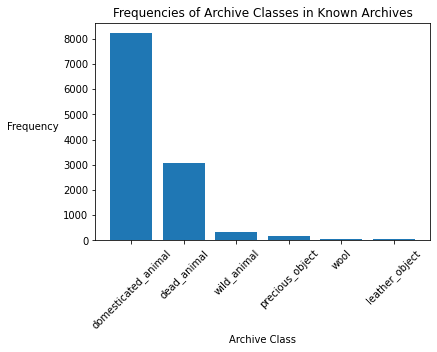

In [ ]:
archive_counts = known['archive_class'].value_counts()


plt.xlabel('Archive Class')
plt.ylabel('Frequency', rotation=0, labelpad=30)
plt.title('Frequencies of Archive Classes in Known Archives')
plt.xticks(rotation=45)
plt.bar(archive_counts.index, archive_counts);

percent_domesticated_animal = archive_counts['domesticated_animal'] / sum(archive_counts)

print('Percent of texts in Domesticated Animal Archive:', percent_domesticated_animal)

In [ ]:
known.shape

(11896, 1084)

In [ ]:
words_df_copy = words_df.copy()
words_df_copy['id_text'] = [int(pn[1:]) for pn in words_df_copy['id_text']]

grouped = words_df_copy.groupby(by=['id_text']).first()
grouped = grouped.fillna(0)

known_copy = known.copy()
known_copy['year'] = grouped.loc[grouped.index.isin(known.index),:]['min_year']

year_counts = known_copy.groupby(by=['year', 'archive_class'], as_index=False).count().set_index('year').loc[:, 'archive_class':'ki']
year_counts_pivoted = year_counts.pivot(columns='archive_class', values='ki').fillna(0)

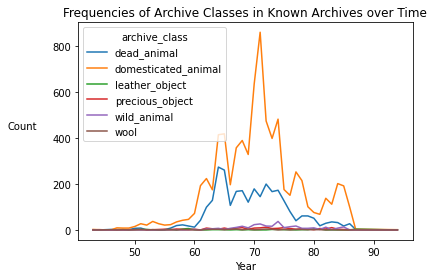

In [ ]:
year_counts_pivoted.drop(index=0).plot();
plt.xlabel('Year')
plt.ylabel('Count', rotation=0, labelpad=30)
plt.title('Frequencies of Archive Classes in Known Archives over Time');

In [ ]:
known

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool,archive_class
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100041,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},1.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
100189,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
100190,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
100191,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
100211,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514376,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},1.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
517184,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,{},0.0,0.0,1.0,0.0,0.0,0.0,dead_animal
519457,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},1.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal


In [ ]:
known.to_csv('output/part_4_known.csv')
known.to_pickle('output/part_4_known.p')
unknown.to_csv('output/part_4_unknown.csv')
unknown.to_pickle('output/part_4_unknown.p')
unknown_0.to_csv('output/part_4_unknown_0.csv')
unknown_0.to_pickle('output/part_4_unknown_0.p')

In [ ]:
#known = pd.read_pickle('part_4_known.p')
#unknown = pd.read_pickle('part_4_unknown.p')
#unknown_0 = pd.read_pickle('part_4_unknown_0.p')

model_weights = {}

#### 1.3.1 PCA/Dimensionality Reduction

Here we perform PCA to find out more about the underlying structure of the dataset. We will analyze the 2 most important principle components and explore how much of the variation of the known set is due to these components.

In [ ]:
#PCA
pca_archive = PCA()
principalComponents_archive = pca_archive.fit_transform(known.loc[:, 'AN.bu.um':'šuʾura'])

In [ ]:
principal_archive_Df = pd.DataFrame(data = principalComponents_archive
             , columns = ['principal component ' + str(i) for i in range(1, 1 + len(principalComponents_archive[0]))])

In [ ]:
len(known.loc[:, 'AN.bu.um':'šuʾura'].columns)

69

In [ ]:
principal_archive_Df

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,principal component 21,principal component 22,principal component 23,principal component 24,principal component 25,principal component 26,principal component 27,principal component 28,principal component 29,principal component 30,principal component 31,principal component 32,principal component 33,principal component 34,principal component 35,principal component 36,principal component 37,principal component 38,principal component 39,principal component 40,principal component 41,principal component 42,principal component 43,principal component 44,principal component 45,principal component 46,principal component 47,principal component 48,principal component 49,principal component 50,principal component 51,principal component 52,principal component 53,principal component 54,principal component 55,principal component 56,principal component 57,principal component 58,principal component 59,principal component 60,principal component 61,principal component 62,principal component 63,principal component 64,principal component 65,principal component 66,principal component 67,principal component 68,principal component 69
0,-0.001153,-0.000651,-0.000559,-0.000524,0.00003,0.000357,-0.000339,-0.000428,-0.000424,-0.000372,-0.000382,-5.157586e-17,2.706112e-15,-0.000481,-0.000306,0.000033,-3.429768e-16,5.923137e-17,4.357782e-17,-2.465750e-16,2.860153e-16,-0.000624,3.966646e-17,2.603275e-16,-4.583354e-17,-2.646101e-17,8.451599e-18,-3.045379e-17,1.346336e-17,9.688025e-17,1.936758e-17,-0.00051,0.000105,-0.000049,-0.000055,-0.000027,-0.000113,-0.000011,-0.000028,-0.000117,-1.617357e-16,-0.000085,-0.000069,-0.000107,0.000015,-0.000031,-0.000042,1.970750e-15,1.869525e-17,9.415297e-16,2.019903e-15,-1.169278e-18,1.894373e-20,-7.211354e-21,-2.128106e-20,1.746307e-21,-2.687171e-20,-2.849700e-20,2.445157e-21,1.963535e-20,3.486655e-21,-2.377182e-22,1.506376e-20,1.319668e-21,-2.913316e-23,4.035962e-23,-2.844907e-23,5.776068e-23,-3.962093e-21
1,-0.001153,-0.000651,-0.000559,-0.000524,0.00003,0.000357,-0.000339,-0.000428,-0.000424,-0.000372,-0.000382,1.564922e-16,2.649608e-15,-0.000481,-0.000306,0.000033,-2.727474e-16,-3.278168e-17,-2.041174e-17,1.211487e-16,4.041074e-17,-0.000624,1.172185e-16,2.181246e-17,3.816922e-17,-1.415496e-17,-8.185121e-17,1.835050e-16,-2.723499e-16,1.982747e-16,-1.303244e-16,-0.00051,0.000105,-0.000049,-0.000055,-0.000027,-0.000113,-0.000011,-0.000028,-0.000117,-6.575466e-17,-0.000085,-0.000069,-0.000107,0.000015,-0.000031,-0.000042,9.619220e-15,-6.600049e-17,-1.429446e-16,-1.916333e-16,-4.540458e-17,3.457458e-19,-6.477865e-19,3.464390e-19,-1.141279e-19,2.092593e-19,1.045044e-18,1.123598e-18,-1.462768e-18,1.294085e-18,4.663841e-19,-3.597813e-19,-4.046188e-20,-1.200163e-20,-1.178408e-20,-6.275206e-21,-1.761853e-20,6.692983e-20
2,-0.001153,-0.000651,-0.000559,-0.000524,0.00003,0.000357,-0.000339,-0.000428,-0.000424,-0.000372,-0.000382,1.535254e-16,2.658846e-15,-0.000481,-0.000306,0.000033,-2.825484e-16,-3.280272e-17,-2.539356e-17,1.231791e-16,4.753436e-17,-0.000624,1.205493e-16,2.333757e-17,3.548553e-17,-1.480301e-17,-8.340641e-17,1.838694e-16,-2.681072e-16,1.870916e-16,-1.443350e-16,-0.00051,0.000105,-0.000049,-0.000055,-0.000027,-0.000113,-0.000011,-0.000028,-0.000117,-6.308277e-17,-0.000085,-0.000069,-0.000107,0.000015,-0.000031,-0.000042,9.504357e-15,-6.459051e-17,-1.301681e-16,-1.933703e-16,-3.696746e-17,1.681898e-19,-6.751741e-19,4.477259e-19,-7.269816e-20,4.045474e-19,1.223637e-18,1.075851e-18,-1.593793e-18,1.216670e-18,2.723570e-19,-4.703521e-19,3.232220e-19,7.222399e-21,5.820028e-21,5

In [ ]:
principal_archive_Df.shape

(11884, 69)

In [ ]:
print('Explained variation per principal component: {}'.format(pca_archive.explained_variance_ratio_))

Explained variation per principal component: [1.48909600e-01 7.68896157e-02 5.44580086e-02 3.84859466e-02
 3.73441272e-02 3.55736929e-02 3.34908306e-02 3.23180930e-02
 3.08607958e-02 2.72465476e-02 2.62104855e-02 2.46991069e-02
 2.46991069e-02 2.46822947e-02 2.23337377e-02 1.90080231e-02
 1.85243302e-02 1.85243302e-02 1.85243302e-02 1.85243302e-02
 1.85243302e-02 1.84959965e-02 1.23495535e-02 1.23495535e-02
 1.23495535e-02 1.23495535e-02 1.23495535e-02 1.23495535e-02
 1.23495535e-02 1.23495535e-02 1.23495535e-02 1.23306530e-02
 1.17690579e-02 1.08917149e-02 1.05830913e-02 9.79182442e-03
 9.66057258e-03 8.53332346e-03 8.13466952e-03 7.97584503e-03
 6.17477673e-03 6.17425099e-03 4.86154090e-03 4.81603581e-03
 4.71709331e-03 2.85814508e-03 1.25376384e-03 1.15905668e-30
 3.84394984e-31 3.83344024e-32 3.01169726e-32 4.83032948e-33
 7.20704280e-34 7.20704280e-34 7.20704280e-34 7.20704280e-34
 7.20704280e-34 7.20704280e-34 7.20704280e-34 7.20704280e-34
 7.20704280e-34 7.20704280e-34 7.2070428

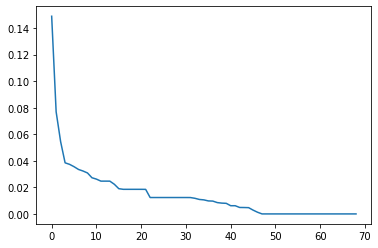

In [ ]:
plt.plot(pca_archive.explained_variance_ratio_)

In [ ]:
known_reindexed = known.reset_index()
known_reindexed

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Principal Component Analysis of Archives",fontsize=20)
targets = ['domesticated_animal', 'wild_animal', 'dead_animal', 'leather_object', 'precious_object', 'wool']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
for target, color in zip(targets,colors):
    indicesToKeep = known_reindexed.index[known_reindexed['archive_class'] == target].tolist()
    plt.scatter(principal_archive_Df.loc[indicesToKeep, 'principal component 1']
               , principal_archive_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

# import seaborn as sns
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="principal component 1", y="principal component 2",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=principal_cifar_Df,
#     legend="full",
#     alpha=0.3
# )

## 2 Simple Modeling Methods

### 2.1 Logistic Regression

Here we will train our model using logistic regression to predict archives based on the features made in the previous subsection.

#### 2.1.1 Logistic Regression by Archive

Here we will train and test a set of 1 vs all Logistic Regression Classifiers which will attempt to classify tablets as either a part of an archive, or not in an archive.

In [ ]:
clf_da = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_da.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'domesticated_animal'])
clf_da.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'domesticated_animal'])

In [ ]:
clf_wa = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_wa.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'wild_animal'])
clf_wa.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'wild_animal'])

In [ ]:
clf_dea = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_dea.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'dead_animal'])
clf_dea.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'dead_animal'])

In [ ]:
clf_lo = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_lo.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'leather_object'])
clf_lo.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'leather_object'])

In [ ]:
clf_po = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_po.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'precious_object'])
clf_po.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'precious_object'])

In [ ]:
clf_w = LogisticRegression(random_state=42, solver='lbfgs', max_iter=200)
clf_w.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'wool'])
clf_w.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'wool'])

In [ ]:
known.loc[:, 'AN.bu.um':'šuʾura']

As we can see the domesticated animal model has the lowest accuracy while the leather object, precious_object, and wool classifiers work fairly well.

#### 2.1.2 Multinomial Logistic Regression

Here we will be using multinomial logistic regression as we have multiple archive which we could classify each text into. We are fitting our data onto the tablets with known archives and then checking the score to see how accurate the model is.

Finally, we append the Logistic Regression prediction as an archive prediction for the tablets without known archives.

In [ ]:
clf_archive = LogisticRegression(random_state=42, solver='lbfgs', max_iter=300)
clf_archive.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
log_reg_score = clf_archive.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
model_weights['LogReg'] = log_reg_score
log_reg_score

0.6918291862811029

In [ ]:
#Predictions for Unknown
unknown["LogReg Predicted Archive"] = clf_archive.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

,ki,kišib,udu,itud,mu,ud,ga,sila,šu,mu.DU,maškim,ekišibak,zabardab,u,maš,šag,lugal,mašgal,kir,a,en,ensik,egia,igikar,ŋiri,ragaba,dubsar,mašda,saŋŋa,amar,mada,akiti,lu,ab,gud,ziga,uzud,ašgar,gukkal,šugid,...,sikiduʾa,gudumdum,šuhugari,šutur,gaguru,nindašura,ekaskalak,usaŋ,nammah,egizid,nisku,gara,saŋ.DUN₃,muhaldimgal,šagiagal,šagiamah,kurunakgal,ugulaʾek,šidimgal,kalam,enkud,in,kiʾana,bahar,hurizum,lagab,ibadu,balla,šembulug,li,niŋsaha,ensi,archive,domesticated_animal,wild_animal,dead_animal,leather_object,precious_object,wool,LogReg Predicted Archive
pn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100217,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0,domesticated_animal
100229,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0,domesticated_animal
100284,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{domesticated_animal, wild_animal}",1.0,1.0,0.0,0.0,0.0,0.0,domesticated_animal
100292,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
100301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
519650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal
519658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{},0.0,0.0,0.0,0.0,0.0,0.0,domesticated_animal


In [ ]:
known['archive_class'].unique()

### 2.2 K Nearest Neighbors

Here we will train our model using k nearest neighbors to predict archives based on the features made in the previous subsection. We are fitting our data onto the tablets with known archives and then checking the score to see how accurate the model is.

We then append the KNN prediction as an archive prediction for the tablets without known archives.

Then, we use different values for K (the number of neighbors we take into consideration when predicting for a tablet) to see how the accuracy changes for different values of K. This can be seen as a form of hyperparameter tuning because we are trying to see which K we should choose to get the highest training accuracy.

In [ ]:
#takes long time to run, so don't run again
list_k = [3, 5, 7, 9, 11, 13]
max_k, max_score = 0, 0
for k in list_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
    knn_score = knn.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
    print("Accuracy for k = %s: " %(k), knn_score)
    if max_score <= knn_score:
        max_score = knn_score
        max_k = k
    

As we can see here, k = 5 and k = 9 have the best training accuracy performance which falls roughly in line with the Logistic Regression classification training accuracy.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=max_k)
knn.fit(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
knn_score = knn.score(known.loc[:, 'AN.bu.um':'šuʾura'], known.loc[:, 'archive_class'])
model_weights['KNN'] = knn_score

In [ ]:
#Predictions for Unknown
unknown["KNN Predicted Archive"] = knn.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

As we can see in the output from the previous cell, we can get different predictions depending on the classifier we choose.

Next we will split the data we have on tablets with known archives into a test and training set to further understant the atraining accuracy. For the next two sections, we will use `X_train` and `y_train` to train the data and `X_test` and `y_test` to test the data. As the known set was split randomly, we presume that both the training and test set are representative of the whole known set, so the two sets are reasonably comparable.

In [ ]:
#Split known into train and test, eventually predict with unknown 
X_train, X_test, y_train, y_test = train_test_split(known.loc[:, 'AN.bu.um':'šuʾura'], 
                                                    known.loc[:, 'archive_class'], 
                                                    test_size=0.2,random_state=0) 

### 2.3 Naive Bayes

Here we will train our model using a Naive Bayes Model to predict archives based on the features made in the previous subsection. Here, we make the assumption that the features are independent of eachother, from which the descriptor _naive_ comes from. So:

$$P(x_i|y; x_1, x_2, ..., x_{i-1}, x_{i+1}, ..., x_n) = P(x_i| y)$$

and:

$$P(x_1, x_2, ..., x_n | y) = \prod_{i=1}^{n} P(x_i | y)$$

Moreover we will be using a Bayesian probability:

$$P(y|x_1, x_2, ..., x_n) = \frac{P(y)P(x_1, x_2, ..., x_n | y)}{P(x_1, x_2, ..., x_n)}$$

eg. the probability of a particular tablet (defined by features $x_1, x_2, ..., x_n$) is in archive $y$, is equal to the probability of getting a tablet from archive $y$ times the probability you would get a particular set of features $x_1, x_2, ..., x_n$ divided by the probability of getting a particular set of features $x_1, x_2, ..., x_n$.

Thus we can simpify this to:

$$P(y|x_1, x_2, ..., x_n) = \frac{P(y)\prod_{i=1}^{n} P(x_i | y)}{P(x_1, x_2, ..., x_n)}$$

Which means the probability of a particular tablet (defined by features $x_1, x_2, ..., x_n$) is in archive $y$ is _proportional_ to 

$$P(y|x_1, x_2, ..., x_n) \propto P(y)\prod_{i=1}^{n} P(x_i | y)$$ probability of getting a tablet from archive $y$ times the product of probabilities of getting a feature $x_i$ given an archive $y$.

We can then use this to calculate the maximizing archive.

$$\hat{y} = \underset{y}{argmax} \; P(y)\prod_{i=1}^{n} P(x_i | y)$$

We are training two models where the first assumes the features are Gaussian random variables and the second assumes the features are Bernoulli random variables.

We are fitting our data onto the tablets with known archives and then checking the score to see how accurate the model is.

Finally, we append the two Naive Bayes predictions as archive predictions for the tablets without known archives.

In [ ]:
#Gaussian
gauss = GaussianNB()
gauss.fit(X_train, y_train)
gauss_nb_score = gauss.score(X_test, y_test)
model_weights['GaussNB'] = gauss_nb_score
gauss_nb_score

We can see than the Gaussian assumption does quite poorly.

In [ ]:
#Predictions for Unknown
unknown["GaussNB Predicted Archive"] = gauss.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

In [ ]:
#Bernoulli
bern = BernoulliNB()
bern.fit(X_train, y_train)
bern_nb_score = bern.score(X_test, y_test)
model_weights['BernoulliNB'] = bern_nb_score
bern_nb_score

However the Bernoulli assumption does quite well.

In [ ]:
#Predictions for Unknown
unknown["BernoulliNB Predicted Archive"] = bern.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

### 2.4 SVM

Here we will train our model using Support Vector Machines to predict archives based on the features made earlier in this section. We are fitting our data onto the tablets with known archives and then checking the score to see how accurate the model is.

Finally, we append the SVM prediction as an archive prediction for the tablets without known archives.

In [ ]:
svm_archive = svm.SVC(kernel='linear')
svm_archive.fit(X_train, y_train)
y_pred = svm_archive.predict(X_test)
svm_score = metrics.accuracy_score(y_test, y_pred)
model_weights['SVM'] = svm_score
print("Accuracy:", svm_score)

In [ ]:
unknown["SVM Predicted Archive"] = svm_archive.predict(unknown.loc[:, 'AN.bu.um':'šuʾura'])
unknown

### 2.5 Random Forest

## 3 Complex Modeling Methods

## 4 Voting Mechanism Between Models

Here we will use the models to determine the archive which to assign to each tablet with an unknown archive. 

We will then augment the words_df with these archives.

In [ ]:
model_weights

In [ ]:
def visualize_archives(data, prediction_name):
    archive_counts = data.value_counts()


    plt.xlabel('Archive Class')
    plt.ylabel('Frequency', rotation=0, labelpad=30)
    plt.title('Frequencies of ' + prediction_name + ' Predicted Archives')
    plt.xticks(rotation=45)
    plt.bar(archive_counts.index, archive_counts);

    percent_domesticated_animal = archive_counts['domesticated_animal'] / sum(archive_counts)

    print('Percent of texts in Domesticated Animal Archive:', percent_domesticated_animal)

In [ ]:
#Log Reg Predictions
visualize_archives(unknown['LogReg Predicted Archive'], 'Logistic Regression')

In [ ]:
#KNN Predictions
visualize_archives(unknown['KNN Predicted Archive'], 'K Nearest Neighbors')

In [ ]:
#Gaussian Naive Bayes Predictions
visualize_archives(unknown['GaussNB Predicted Archive'], 'Gaussian Naive Bayes')

In [ ]:
#Bernoulli Naive Bayes Predictions
visualize_archives(unknown['BernoulliNB Predicted Archive'], 'Bernoulli Naive Bayes')

In [ ]:
#SVM Predictions
visualize_archives(unknown['SVM Predicted Archive'], 'Support Vector Machines Naive Bayes')

In [ ]:
def weighted_voting(row):
    votes = {} # create empty voting dictionary
    # tally votes
    for model in row.index:
        model_name = model[:-18] # remove ' Predicted Archive' from column name
        prediction = row[model]
        if prediction not in votes.keys():
            votes[prediction] = model_weights[model_name] # if the prediction isn't in the list of voting categories, add it with a weight equal to the current model weight 
        else:
            votes[prediction] += model_weights[model_name] # else, add model weight to the prediction
    return max(votes, key=votes.get) # use the values to get the prediction with the greatest weight

In [ ]:
predicted_archives = unknown.loc[:, 'LogReg Predicted Archive':
                                   'SVM Predicted Archive'].copy() # get predictions
weighted_prediction = predicted_archives.apply(weighted_voting, axis=1) #apply voting mechanism on each row and return 'winning' prediction

In [ ]:
weighted_prediction[weighted_prediction != 'domesticated_animal']

In [ ]:
words_df

In [ ]:
archive_class = known['archive_class'].copy().append(weighted_prediction)
words_df['archive_class'] = words_df.apply(lambda row: archive_class[int(row['id_text'][1:])], axis=1)

In [ ]:
words_df

## 5 Save Results in CSV file & Pickle